<h1>Kunskapkontroll-AdventureWorks Database </h1>

<h3>Descriptive Summary </h3>

AdventureWorks Database is a collection of fictional business data models, encompassing scenarios like sales, purchasing, product management, and human resources for a bicycle and accessories company. 

This analysis examines the company's human resource data, focusing on key metrics such as departmental resource allocation, gender and age distribution, and employee sick hours. The objective is to provide management with actionable insights into workforce utilization, diversity, and employee health, enabling informed decision-making to optimize resource efficiency, promote inclusivity, and enhance overall employee well-being.





This section of the code handles the preparation for importing the necessary database, creating an engine, and establishing a connection to the server using the server name, username, and password. The SQLAlchemy library is utilized to streamline communication between the Python program and SQL Server Management Studio, ensuring efficient data interaction and management.

In [2]:
#Import necessary libraries
from sqlalchemy import create_engine, Table, inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Creat engine
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

#Connect server Name, username and password
engine = new_engine('mssql', 'DESKTOP-JNP59V3', 'AdventureWorks2022', integrated_security=True)

print(type(engine))

mssql://DESKTOP-JNP59V3/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server
<class 'sqlalchemy.engine.base.Engine'>


To begin, we provide an overview of the schemas to understand the business information contained within the database. For clarity, we have excluded system schemas such as 'db_', 'sys', 'INFORMATION_SCHEMA', 'guest', and 'dbo'. As illustrated, the primary schemas are organized into five key business areas: Human Resources, Person, Production, Purchasing, and Sales.

In [3]:
connection = engine.connect()
inspector = inspect(engine)
schemas = inspector.get_schema_names()

valid_schemas = [schema for schema in schemas if not schema.startswith(('db_','sys','INFORMATION','guest','dbo'))]
         
for index, schema in enumerate(valid_schemas, start=1):
       print(f"{index}. {schema}")

1. HumanResources
2. Person
3. Production
4. Purchasing
5. Sales


As mentioned, this report will focus on the Human Resources schema, which includes the following six tables

In [4]:
print(inspector.get_table_names(schema='HumanResources'))

['Department', 'Employee', 'EmployeeDepartmentHistory', 'EmployeePayHistory', 'JobCandidate', 'Shift']


<b>Statistical Analysis of Average Age </b>

First, we observe that the average age of employees in the company is approximately 46 years. Breaking it down further, the average age for male employees is 45.82, while for female employees, it is slightly higher at 46.75. 

In [5]:
#sql qurey average age
query = """
SELECT Gender, BirthDate From HumanResources.Employee"""
df = pd.read_sql(query, con=connection)

from datetime import datetime

def calculate_age(birthdate):
    today = datetime.today()
    return today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))

df['BirthDate'] = pd.to_datetime(df['BirthDate'])
df['Age'] = df['BirthDate'].apply(calculate_age)

overall_avg_age = df['Age'].mean()
avg_age_male = df[df['Gender'] == 'M']['Age'].mean()
avg_age_female = df[df['Gender'] == 'F']['Age'].mean()

print(f"Overall Average Age: {overall_avg_age:.2f}")
print(f"Average Age for Males: {avg_age_male:.2f}")
print(f"Average Age for Females: {avg_age_female:.2f}")

Overall Average Age: 46.09
Average Age for Males: 45.82
Average Age for Females: 46.75


<b>Statistical Analysis of Gender Distribution by Department, Job Title and Organisation Level </b>

Examining the gender distribution of employees, we find that the majority of the workforce is male, representing 71% (206 out of 290 total employees).

  Gender  TotalEmployees
0      F              84
1      M             206


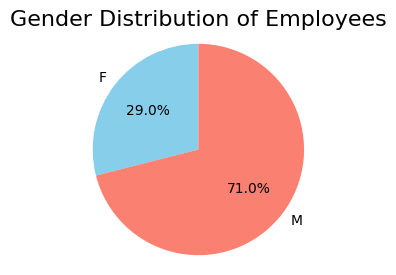

In [6]:
# gender distribution
query = """
SELECT Gender, COUNT(*) AS TotalEmployees
FROM HumanResources.Employee
GROUP BY Gender
"""
df = pd.read_sql(query, con=connection)
print(df.head(10))

# Create the pie chart
plt.figure(figsize=(3, 3))
plt.pie(
    df['TotalEmployees'],
    labels=df['Gender'],
    autopct='%1.1f%%',
    colors=['skyblue', 'salmon'],
    startangle=90
)
plt.title('Gender Distribution of Employees', fontsize=16)
plt.axis('equal')
plt.show()


The heavy concentration (61.72%) of employees in Production suggests a business model highly dependent on manufacturing or operations, with limited workforce allocation to strategic functions like Sales (6.21%), R&D (1.38%), and Executive leadership (0.69%).

                    Department  NumberOfEmployees Percentage
0                   Production                179     61.72%
1                        Sales                 18      6.21%
2                   Purchasing                 12      4.14%
3                      Finance                 10      3.45%
4         Information Services                 10      3.45%
5                    Marketing                  9       3.1%
6   Facilities and Maintenance                  7      2.41%
7                  Engineering                  6      2.07%
8              Human Resources                  6      2.07%
9            Quality Assurance                  6      2.07%
10          Production Control                  6      2.07%
11      Shipping and Receiving                  6      2.07%
12            Document Control                  5      1.72%
13                 Tool Design                  4      1.38%
14    Research and Development                  4      1.38%
15                   Exe

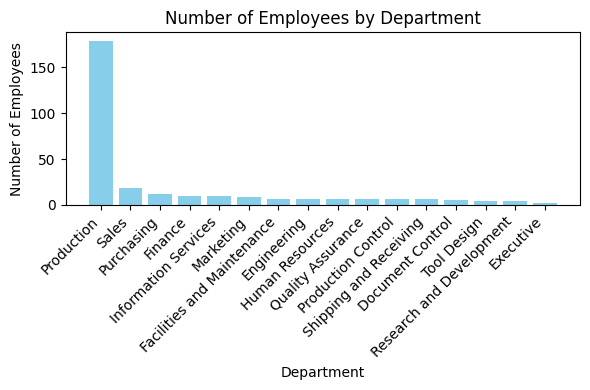

In [8]:
# Department
query = """
SELECT 
    Department,
    COUNT(BusinessEntityID) AS NumberOfEmployees
FROM 
    HumanResources.vEmployeeDepartment
GROUP BY 
    Department
ORDER BY 
    NumberOfEmployees DESC
"""

# Load data into a DataFrame
df = pd.read_sql(query, con=connection)
total_employees = df['NumberOfEmployees'].sum()
df['Percentage'] =((df['NumberOfEmployees'] / total_employees) * 100).round(2).astype(str) + '%'
print(df.head(30))

# Create a bar chart
plt.figure(figsize=(6, 4))
plt.bar(df['Department'], df['NumberOfEmployees'], color='skyblue')
plt.xlabel('Department')
plt.ylabel('Number of Employees')
plt.title('Number of Employees by Department')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

The workforce is predominantly male, especially in Production (152M, 46F), Production Control (8M, 0F), and Engineering (6M, 3F), highlighting a gender imbalance in technical and operational roles. Finance (8F, 5M) and Executive (3F, 1M) have higher female representation. 

Gender                         F      M
Name                                   
Document Control             1.0    4.0
Engineering                  3.0    6.0
Executive                    3.0    1.0
Facilities and Maintenance   2.0    5.0
Finance                      8.0    5.0
Human Resources              2.0    4.0
Information Services         4.0    6.0
Marketing                    7.0    7.0
Production                  46.0  152.0
Production Control           0.0    8.0
Purchasing                   6.0   11.0
Quality Assurance            3.0    6.0
Research and Development     2.0    2.0
Sales                        7.0   11.0
Shipping and Receiving       2.0    4.0
Tool Design                  1.0    5.0


<Figure size 1200x600 with 0 Axes>

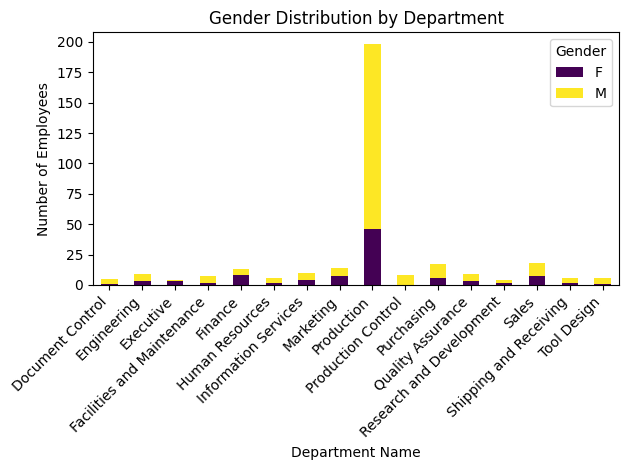

In [9]:
# Gender Distribution by Department
query = """
SELECT 
    Name,
    Gender,
    COUNT(*) AS Count
FROM 
    dbo.DeptGender
GROUP BY 
    Name, Gender
ORDER BY 
    Gender DESC;
"""
df = pd.read_sql(query, con=connection)

# Pivot the data for better visualization
pivot_df = df.pivot(index='Name', columns='Gender', values='Count').fillna(0)
print(pivot_df.head(100))

# Plot the data
plt.figure(figsize=(12, 6))
pivot_df.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Gender Distribution by Department')
plt.xlabel('Department Name')
plt.ylabel('Number of Employees')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Gender')
plt.show()

A detailed breakdown of gender distribution by Job title and organizational level reveals a male-dominated workforce across all levels. Notably, Level 1, which includes managers and VPs, has a balanced gender distribution. However, the male CEO is not included in this data.

In [15]:
# Gender Distribution by Jobtitle
query = """
SELECT 
    JobTitle,
    Gender,
    COUNT(*) AS NumberOfEmployees
FROM HumanResources.Employee
GROUP BY JobTitle, Gender
ORDER BY NumberOfEmployees DESC;
"""

# Load data
df = pd.read_sql(query, con=connection)

# Pivot the table
pivot_df = df.pivot_table(
    index='JobTitle',
    columns='Gender',
    values='NumberOfEmployees',
    fill_value=0
).reset_index()

pivot_df.columns = ['JobTitle', 'Female', 'Male']
pivot_df['TotalEmployees'] = pivot_df['Male'] + pivot_df['Female']
pivot_df = pivot_df.sort_values (by='TotalEmployees', ascending=False)

pivot_df['Male (%)'] = (pivot_df['Male'] / pivot_df['TotalEmployees'] * 100).round(2)
pivot_df['Female (%)'] = (pivot_df['Female'] / pivot_df['TotalEmployees'] * 100).round(2)

pivot_df.head(100)

,JobTitle,Female,Male,TotalEmployees,Male (%),Female (%)
46,Production Technician - WC50,7.0,19.0,26.0,73.08,26.92
44,Production Technician - WC40,3.0,23.0,26.0,88.46,11.54
47,Production Technician - WC60,6.0,20.0,26.0,76.92,23.08
43,Production Technician - WC30,5.0,20.0,25.0,80.00,20.00
42,Production Technician - WC20,6.0,16.0,22.0,72.73,27.27
...,...,...,...,...,...,...
51,Quality Assurance Supervisor,0.0,1.0,1.0,100.00,0.00
61,Shipping and Receiving Supervisor,0.0,1.0,1.0,100.00,0.00
64,Vice President of Engineering,1.0,0.0,1.0,0.00,100.00
65,Vice President of Production,0.0,1.0,1.0,100.00,0.00


In [20]:
# Gender Distribution by Organization Level
query = """
SELECT 
    OrganizationLevel,
    Gender,
    COUNT(*) AS NumberOfEmployees
FROM HumanResources.Employee
GROUP BY OrganizationLevel, Gender
ORDER BY NumberOfEmployees DESC;
"""

# Load data
df = pd.read_sql(query, con=connection)

# Pivot the table
pivot_df = df.pivot_table(
    index='OrganizationLevel',  
    columns='Gender',
    values='NumberOfEmployees',
    fill_value=0
).reset_index()

pivot_df.columns = ['OrganizationLevel', 'Female', 'Male']  # Update column names
pivot_df['TotalEmployees'] = pivot_df['Male'] + pivot_df['Female']
pivot_df = pivot_df.sort_values(by='TotalEmployees', ascending=False)

pivot_df['Male (%)'] = (pivot_df['Male'] / pivot_df['TotalEmployees'] * 100).round(2)
pivot_df['Female (%)'] = (pivot_df['Female'] / pivot_df['TotalEmployees'] * 100).round(2)

pivot_df.head(100)

,OrganizationLevel,Female,Male,TotalEmployees,Male (%),Female (%)
3,4.0,51.0,139.0,190.0,73.16,26.84
2,3.0,20.0,46.0,66.0,69.70,30.30
1,2.0,10.0,17.0,27.0,62.96,37.04
0,1.0,3.0,3.0,6.0,50.00,50.00


<b>Statistical Analysis of Sick Leave Hours </b>


The Production department has the highest total sick hours (7,971 hours) due to its large workforce, while Facilities & Maintenance and Shipping & Receiving have the highest average sick hours per employee (64 and 67 hours, respectively), exceeding the confidence interval upper limit (~53.39 hours). This suggests that physical labor-intensive roles may lead to higher absenteeism, possibly due to workplace conditions or health risks.

In [ ]:
#SickLeaverHours by department
query = """SELECT 
    d.DepartmentID, 
    d.Name AS DepartmentName,
    SUM(e.SickLeaveHours) AS total_sick_hours, 
    COUNT(e.BusinessEntityID) AS employee_count,
    AVG(e.SickLeaveHours) AS avg_sick_hours
FROM 
    HumanResources.Employee e
JOIN 
    HumanResources.EmployeeDepartmentHistory edh 
    ON e.BusinessEntityID = edh.BusinessEntityID
JOIN 
    HumanResources.Department d 
    ON edh.DepartmentID = d.DepartmentID
GROUP BY 
    d.DepartmentID, d.Name
ORDER BY 
    avg_sick_hours; """

df_sickhours= pd.read_sql(query, con=connection)


In [24]:
# Add confidence interval calculation

from scipy import stats
def calculate_confidence_interval(data, confidence_level=0.95):
    n = len(data)  
    mean = np.mean(data) 
    std = np.std(data, ddof=1)  
    se = std / np.sqrt(n) 
    margin_of_error = stats.t.ppf((1 + confidence_level) / 2, df=n-1) * se  
    return mean - margin_of_error, mean + margin_of_error

lower_bound, upper_bound = calculate_confidence_interval(df_sickhours['avg_sick_hours'])

df_sickhours['avg_sick_hours_lower_ci'] = lower_bound
df_sickhours['avg_sick_hours_upper_ci'] = upper_bound

df_sickhours

,DepartmentID,DepartmentName,total_sick_hours,employee_count,avg_sick_hours,avg_sick_hours_lower_ci,avg_sick_hours_upper_ci
0,1,Engineering,209,7,29,41.989048,53.385952
1,3,Sales,605,18,33,41.989048,53.385952
2,2,Tool Design,151,4,37,41.989048,53.385952
3,4,Marketing,420,10,42,41.989048,53.385952
4,8,Production Control,255,6,42,41.989048,53.385952
5,7,Production,7971,180,44,41.989048,53.385952
6,16,Executive,89,2,44,41.989048,53.385952
7,9,Human Resources,273,6,45,41.989048,53.385952
8,10,Finance,515,11,46,41.989048,53.385952
9,5,Purchasing,604,13,46,41.989048,53.385952


<h3>Conclusions</h3>


The analysis comprises three key areas: Employees’ Average Age, Gender Distribution by Department, Job Title, and Organisation Level, and Sick Leave Hours. The findings and conslusions are as follows:

<b>Employee Age</b>

The company’s workforce has an average age of 46 years, with a relatively balanced age distribution across genders. However, the female workforce is slightly older. Employee's average age also reflects an aging trend in the organization.

<b>Gender Distribution</b>

The company is male-dominated, particularly in the Production department, which aligns with its focus on manufacturing and operations. Departments like Sales, Marketing, IT, and Engineering are leaner, indicating a traditional manufacturing orientation. The R&D department, with only 4 employees, suggests a need for greater innovation capacity. A significant gender gap exists in technical and operational roles, highlighting an opportunity to promote female participation in these areas. On a positive note, management exhibits a balanced gender distribution, fostering equal opportunities for leadership growth.

<b>Sick Leave Hours Analysis</b>

The average sick leave hours fall within a consistent range of [41.98, 53.38] across most departments. However, Facilities & Maintenance (64 avg. sick hours) and Shipping & Receiving (67 avg. sick hours) exceed this range, indicating higher absenteeism likely due to the physically demanding nature of these roles. This may point to workplace health risks, job strain, or insufficient safety measures, warranting further investigation.

<h3>Executive Summary</h3>

This report offers a detailed analysis of the company's human resources data, with a focus on key workforce demographics, including age, gender distribution, and employee well-being.

The average employee age is approximately 46 years. The aging trend in the organization highlights potential challenges for recruitment and workforce planning. To address this, the company could consider initiatives such as hiring more young talent or introducing junior trainee programs to create a more balanced age distribution. Additionally, the aging workforce suggests opportunities for tailored wellness programs and succession planning to ensure long-term organizational resilience.

Gender distribution analysis reveals a significant gender disparity. A detailed breakdown by organizational level shows male dominance across all tiers, emphasizing the need for targeted diversity and inclusion initiatives to address gender imbalances, particularly in leadership and mid-level management roles. Promoting gender equity and supporting career advancement for underrepresented groups can foster a more inclusive workplace culture and drive organizational success.

Given that the company’s main workforce is concentrated in production and operations, expanding teams in sales, marketing, and business development could be a strategic move to grow the business to the next level. Additionally, innovation is critical for staying competitive in the market. Increasing the workforce in R&D, engineering, or IT could be a strong strategy for future development and product innovation.

The current average sick leave hours can serve as a benchmark for the company’s strategy to improve employee well-being. Reducing sick leave hours could be a key performance indicator (KPI) for the HR and management teams to focus on. Creating a healthy and balanced work environment is not only a social responsibility but also a way to enhance productivity and operational efficiency.

By addressing these areas, the company can optimize resource allocation, enhance employee well-being, and strengthen its commitment to diversity and inclusion, ultimately driving sustainable growth and innovation. This analysis serves as a foundation for actionable strategies to improve workforce management and organizational performance.

Oral Presentation data: Feb 2nd 20225 